# Google Play Applications Analysis

$Hipotesis$

  Mediante el analisis de los datos de las aplicaciones del Play Store esperamos determinar el 
perfil de la aplicacion que mas instalaciones lograra.


> Importando las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 
import seaborn as sns
%matplotlib inline

>Importamos los datos del CSV a un Data frame

In [2]:
# The code was removed by Watson Studio for sharing.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# Ejecutamos la funcion dtypes para ver que tipos de datos tenemos en cada feature
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

## Limpieza y preparaciones basicas de la data

    
 Vemos que hay columnas que tienen datos numericos pero estan definidas como objetos, y no solo estan definidas como objeto sino que tambien tienen caracteres que no nos permitirian realizar operaciones con ellos por lo tanto vamos a encargaronos de eso.

In [4]:
#Convertimos a float la columna Review.
df["Reviews"]=df.Reviews.astype(float)

ValueError: could not convert string to float: '3.0M'

In [23]:
# Observamos la columna que da error.
df[df["Reviews"] == "3.0M"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,8.0 and up,0,Free,Paid,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,NaN,Free,0,Everyone,NaN,"February 11, 2018",...,0,1,0,0,0,0,0,0,0,0


Vemos que la fila tiene datos que no condicen. Tiene corridos los datos y dos columnas en NaN por lo tanto no nos sirve para el analysis.

In [4]:
#Borramos la fila ya que tiene multiples errores
df.drop(10472,axis=0,inplace=True)

In [5]:
#Transformamos la columna reviews a enteros para poder trabajar con ellos luego
df["Reviews"]=df.Reviews.astype(int)
df["Reviews"].describe()

count    1.084000e+04
mean     4.441529e+05
std      2.927761e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.477550e+04
max      7.815831e+07
Name: Reviews, dtype: float64

Observamos que la columna **Reviews** quedo lista.

Tambien se observa a simple vista que la columna **Installs** declarada como objeto por los caracteres que incluye pordria ser de utilidad para trabajar siendo numerica

In [6]:
#Reemplaza caracteres no deseados como el + en la columna Installs.
df["Installs"].replace("\+","",regex=True,inplace=True)
#Reemplaza caracteres no deseados como el , en la columna Installs.
df["Installs"].replace("\,","",regex=True,inplace=True)
#Cambiamos el tipo de datos de la columna Installs a float.
df["Installs"]=df.Installs.astype(int)
df["Installs"].describe()

count    1.084000e+04
mean     1.546434e+07
std      8.502936e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

La columna **Reviews** quedo lista para luego ser utilizada.

La columna **Size** declarada como objeto por los caracteres que incluye aunque representa el numero de bytes que ocupa en la memoria la aplicacion pordria ser de utilidad para trabajar siendo numerica.

In [7]:
# Definimos la funcion k_transform para transformar a Megabytes todo los valores de la columna Size
def k_transform(size):
    if 'k' in size:
        x=float(size.strip('k'))
        return round((x/1024),3)
    elif 'M' in size:
        x=float(size.strip('M'))
        return x
    else:
        size = np.nan
        return size

In [8]:
df["Size"]=df.Size.apply(k_transform)

In [9]:
df["Size"].dtype

dtype('float64')

Finalizamos con la transformacion de la columna **Size** a numeros punto flotantes representando el tamaño en megas de cada aplicacion.

>Ahora revisamos los valores nulos en el df

In [10]:
'''
Ejecutamos la funcion isnull en conjunto con sum para obtener la sumatiora de datos no numericos
de todas las columnas del def.
'''

df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Empezamos por las Features de menor cantidad de valores nulos. 

En el caso de **Android Ver** vamos a utilizar el metodo de reemplazo por el valor que mas frecuente en la columna o tambien conocido como `MODE`

¿Porque uso el metodo de mode? Al ser una variable continua y ser pocos valores no numericos, utilizar el valor mas frecuente para reemplazar los valores no numericos es una alternativa robusta y que tiene un impacto muy bajo sobre la distribucion de los datos de la columna.

In [11]:
'''
Ejecutamos la funcion de la libreria ScyPy mode la cual nos devolvera 
el valor del mode y la cantidad de veces que este se repite en la columna
'''
print(stats.mode(df["Android Ver"]))
df["Android Ver"].value_counts().to_frame().head()

ModeResult(mode=array(['4.1 and up'], dtype=object), count=array([2451]))


/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,Android Ver
4.1 and up,2451
4.0.3 and up,1501
4.0 and up,1375
Varies with device,1362
4.4 and up,980


In [12]:
# Rellenamos entonces los valores NaN con el valor del mode y observamos que luego no quedan valores nulos.
df['Android Ver'].fillna('4.1 and up',inplace=True)
df['Android Ver'].isnull().sum()

0

Utilizamos el mismo criterio para la columna **Current Ver** y **Type**

In [13]:
df["Current Ver"].value_counts().to_frame().head(10)

,Current Ver
Varies with device,1459
1.0,809
1.1,264
1.2,178
2.0,151
1.3,145
1.0.0,136
1.0.1,119
1.4,88
1.5,81


In [14]:
df['Current Ver'].fillna('Varies with device',inplace=True)
df['Current Ver'].isnull().sum()

0

In [15]:
df["Type"].value_counts().to_frame()

,Type
Free,10039
Paid,800


In [16]:
df["Type"].fillna("Free",inplace=True)
df["Type"].isnull().sum()

0

En las Columnas **Rating** y **Size** el porcentaje de NaN es muy elevado, por lo tanto las dejaremos como tal para que no afecte en analisis de las otras categorias.

Ahora trabajamos sobre las variables continuas con metodos de `Encoding` para un mejor aprovechamiento de las mismas.

In [17]:
#Creamos las columnas dummy
dummy_variable_1 = pd.get_dummies(df["Category"])
dummy_variable_2 = pd.get_dummies(df["Current Ver"])
dummy_variable_3 = pd.get_dummies(df["Last Updated"])
dummy_variable_4 = pd.get_dummies(df["Android Ver"])
dummy_variable_5 = pd.get_dummies(df["Type"])
dummy_variable_6 = pd.get_dummies(df["Content Rating"])

In [18]:
for i in dummy_variable_1.columns:
    df[i]=dummy_variable_1[i]

In [19]:
for i in dummy_variable_2.columns:
    df[i]=dummy_variable_2[i]

In [20]:
for i in dummy_variable_3.columns:
    df[i]=dummy_variable_3[i]

In [21]:
for i in dummy_variable_4.columns:
    df[i]=dummy_variable_4[i]

In [22]:
for i in dummy_variable_5.columns:
    df[i]=dummy_variable_5[i]

In [23]:
for i in dummy_variable_6.columns:
    df[i]=dummy_variable_6[i]

Antes de pasar a la visualizacion para obtener como paso anterior vamos a `Standarizar` la data

In [24]:
df_tonorm=df[['Rating','Reviews','Size','Installs']]
columns_df_tonorm=df_tonorm.columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df_tonorm), columns = columns_df_tonorm)

df[['Rating','Reviews','Size','Installs']] = df_norm



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Visualizacion de la data

Realizaremos algunos graficos para lograr un mejor entendimiento de la data

(-5, 5)

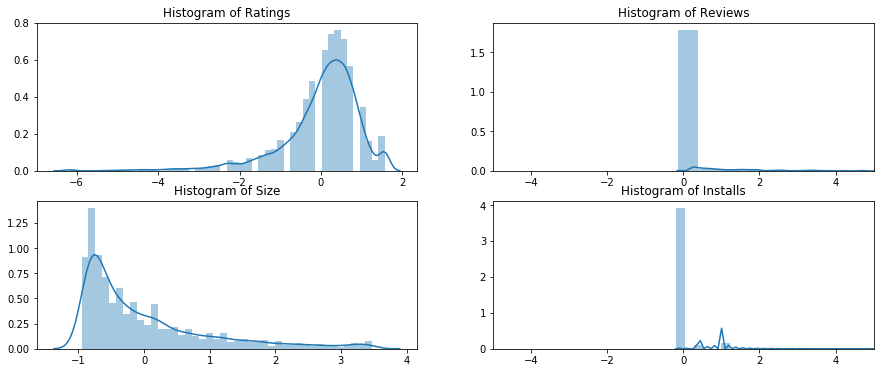

In [26]:
#Realizamos algunos Histogramas para entender la distribucion de la data.
fig = plt.figure(figsize=(15,6)) # create figure

# create subplots
ax0 = fig.add_subplot(2, 2, 1) 
ax1 = fig.add_subplot(2, 2, 2) 
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)  

# Subplot 1: Histogram of Ratings
sns.distplot(df[['Rating']].dropna(), ax=ax0)
ax0.set_title('Histogram of Ratings')


# Subplot 2: Histogram of Reviews
sns.distplot(df[['Reviews']].dropna(), ax=ax1)
ax1.set_title('Histogram of Reviews')
ax1.set_xlim(-5,5)

# Subplot 3: Histogram of Size
sns.distplot(df[['Size']].dropna(), ax=ax2)
ax2.set_title('Histogram of Size')


# Subplot 4: Histogram of Installs
sns.distplot(df[['Installs']].dropna(), ax=ax3)
ax3.set_title('Histogram of Installs')
ax3.set_xlim(-5,5)


In [30]:
df[['Rating','Reviews','Size','Installs']].describe()

,Rating,Reviews,Size,Installs
count,9365.000000,10839.000000,9144.000000,10839.000000
mean,-0.000002,0.000010,0.000084,0.000006
std,1.000107,1.000092,1.000077,1.000092
min,-6.195285,-0.151711,-0.952201,-0.181879
25%,-0.372206,-0.151698,-0.735624,-0.181867
50%,0.210102,-0.150996,-0.377024,-0.180703
75%,0.598307,-0.133046,0.375593,-0.123073
max,1.568820,26.545114,3.474604,11.579307


> Graficamos y analizamos la correlacion de las diferentes caracteristicas con las Instalaciones

In [31]:
df[['Rating','Reviews','Size','Installs']].corr()

,Rating,Reviews,Size,Installs
Rating,1.000000,0.068142,0.083746,0.051355
Reviews,0.068142,1.000000,0.238216,0.643122
Size,0.083746,0.238216,1.000000,0.164798
Installs,0.051355,0.643122,0.164798,1.000000


In [33]:
#Armamos los df test para probar las correlaciones
df_test_Cat=pd.concat([df["Installs"], dummy_variable_1], axis=1)
df_test_Curr=pd.concat([df["Installs"], dummy_variable_2], axis=1)
df_test_Last=pd.concat([df["Installs"], dummy_variable_3], axis=1)
df_test_Andr=pd.concat([df["Installs"], dummy_variable_4], axis=1)
df_test_Typ=pd.concat([df["Installs"], dummy_variable_5], axis=1)
df_test_Cont=pd.concat([df["Installs"], dummy_variable_6], axis=1)

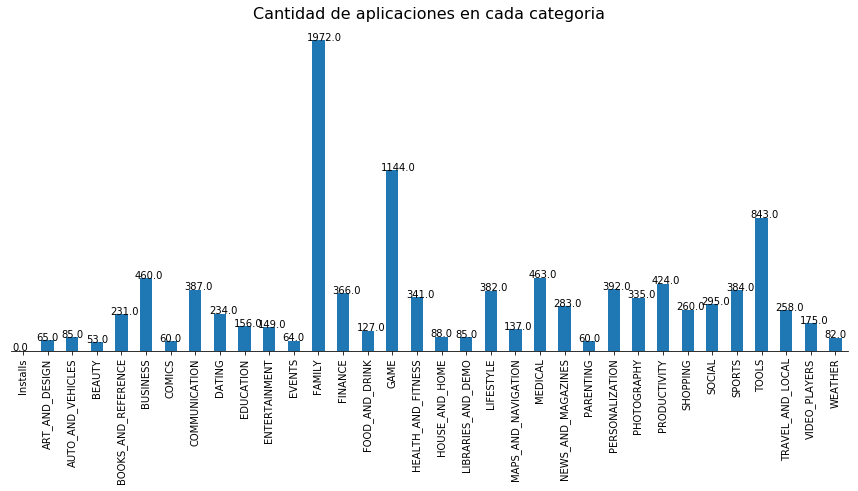

In [159]:
ax9 = df_test_Cat[df_test_Cat[df_test_Cat.columns[1:]]==1].sum().plot(kind='bar',figsize=(15,6))
plt.title('Cantidad de aplicaciones en cada categoria', fontsize = 16)
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.spines['left'].set_visible(False)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)

for p in ax9.patches:
    ax9.annotate("{}".format(p.get_height()),
                 
                xy=(p.get_x()-0.2, p.get_height()+0.6))


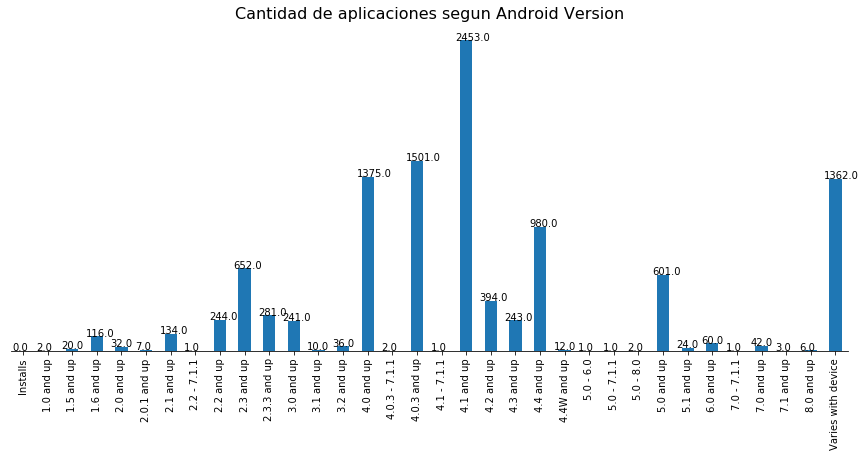

In [161]:
ax10 = df_test_Andr[df_test_Andr[df_test_Andr.columns[1:]]==1].sum().plot(kind='bar',figsize=(15,6))
plt.title('Cantidad de aplicaciones segun Android Version', fontsize = 16)
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.spines['left'].set_visible(False)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)

for p in ax10.patches:
    ax10.annotate("{}".format(p.get_height()),
                 
                xy=(p.get_x()-0.2, p.get_height()+0.6))

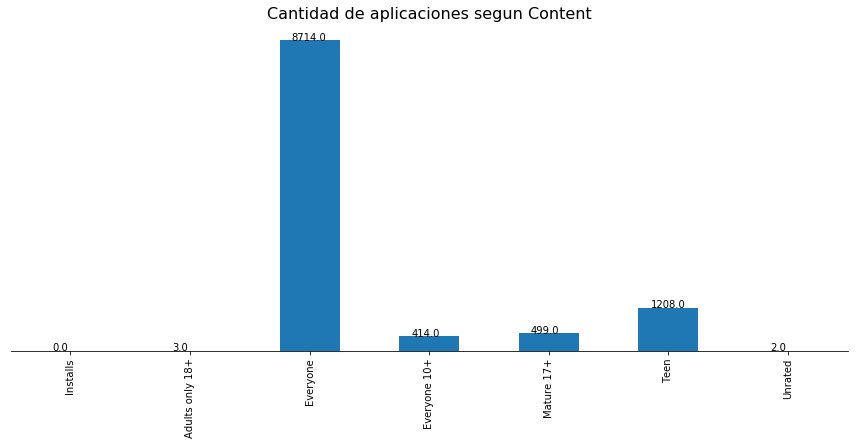

In [165]:
ax11 = df_test_Cont[df_test_Cont[df_test_Cont.columns[1:]]==1].sum().plot(kind='bar',figsize=(15,6))
plt.title('Cantidad de aplicaciones segun Content', fontsize = 16)
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['left'].set_visible(False)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)

for p in ax11.patches:
    ax11.annotate("{}".format(p.get_height()),
                 
                xy=(p.get_x()+0.1, p.get_height()+0.6))

### Ahora usaremos la ayuda de un modelo del paquete Statsmodels para realizar el test de la hipotesis nula propuesta: 

- Hipotesis nula: **"Cada una de las Features tiene impacto en la cantidad de instalaciones"**

- Usaremos el test: **t-test**, ya que compararemos cada una de las Features con las Instalaciones

In [61]:
#Entrenamos al modelo de Ordinary Least Squares con la data de Current Ver para buscar la correlacion con la instalaciones
import statsmodels.api as sm
X_cv=df_test_Curr.iloc[:-1,1:]
X_cv=sm.add_constant(X_cv)
y_cv=df_test_Curr.iloc[:-1,0]

results_cv = sm.OLS(y_cv,X_cv).fit()

In [37]:
results_cv.summary()

In [36]:
df_results_cv=pd.DataFrame({'t-values': list(results_cv.tvalues), 'p-values': list(results_cv.pvalues)},index= results_cv.pvalues.index)
curr_ver_signif_corr=list(df_results_cv[df_results_cv['p-values']<=0.05].index)
df_results_cv[df_results_cv['p-values']<=0.05]

,t-values,p-values
const,-4.741933,2.153472e-06
1.0,-2.761381,5.768860e-03
1.129.0.2,15.835295,1.233998e-55
1.37.2,2.217329,2.662857e-02
1.4.77,11.975160,9.123777e-33
1.49.1,14.662594,4.680634e-48
1.90.0,29.597167,8.628884e-183
10.322.16,2.217329,2.662857e-02
12.8.5.1121,10.372181,4.779414e-25
16.0.10325.20043,9.023595,2.246890e-19


Text(0.5, 1.0, 'Boxplot of the Current Ver Varies with device')

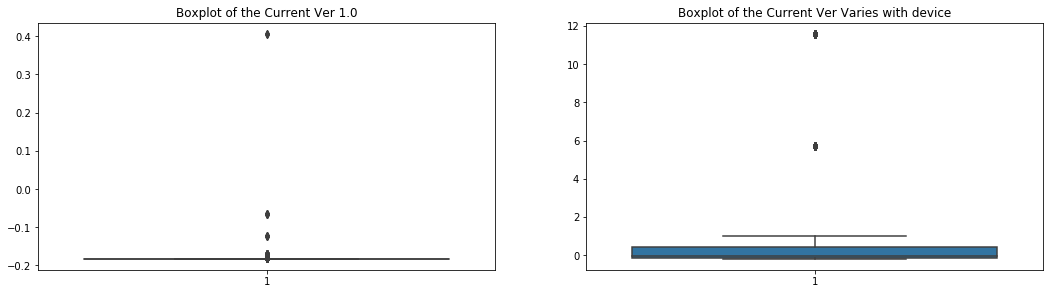

In [131]:
#Realizamos algunos BoxPlots para entender la distribucion de la data.
fig = plt.figure(figsize=(18,10)) # create figure

# create subplots
ax5 = fig.add_subplot(2, 2, 1) 
ax6 = fig.add_subplot(2, 2, 2) 
#ax7 = fig.add_subplot(2, 2, 3)
#ax8 = fig.add_subplot(2, 2, 4)

#Subplot 1
ax5 = sns.boxplot(x=df[df[curr_ver_signif_corr[1]]==1][curr_ver_signif_corr[1]].values, y=df[df[curr_ver_signif_corr[1]]==1]['Installs'].values, ax=ax5)
ax5.set_title('Boxplot of the Current Ver ' + curr_ver_signif_corr[1])

#Subplot 2
ax6 = sns.boxplot(x=df[df[curr_ver_signif_corr[28]]==1][curr_ver_signif_corr[28]].values, y=df[df[curr_ver_signif_corr[28]]==1]['Installs'].values, ax=ax6)
ax6.set_title('Boxplot of the Current Ver ' + curr_ver_signif_corr[28])

In [107]:
#Entrenamos al modelo de Ordinary Least Squares con la data de Category para buscar la correlacion con la instalaciones
import statsmodels.api as sm
X=df_test_Cat.iloc[:-1,1:]
X=sm.add_constant(X)
y=df_test_Cat.iloc[:-1,0]

results = sm.OLS(y,X).fit()

In [101]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Installs   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     16.49
Date:                Tue, 11 Feb 2020   Prob (F-statistic):           1.16e-88
Time:                        18:13:19   Log-Likelihood:                -15122.
No. Observations:               10839   AIC:                         3.031e+04
Df Residuals:                   10806   BIC:                         3.055e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.568e+11    1.4e+12      0.112      0.911   -2.59e+12    2.91e+12
ART_AND_DESIGN      -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
AUTO_AND_VEHICLES   -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
BEAUTY              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
BOOKS_AND_REFERENCE -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
BUSINESS            -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
COMICS              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
COMMUNICATION       -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
DATING              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
EDUCATION           -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
ENTERTAINMENT       -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
EVENTS              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
FAMILY              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
FINANCE             -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
FOOD_AND_DRINK      -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
GAME                -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
HEALTH_AND_FITNESS  -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
HOUSE_AND_HOME      -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
LIBRARIES_AND_DEMO  -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
LIFESTYLE           -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
MAPS_AND_NAVIGATION -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
MEDICAL             -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
NEWS_AND_MAGAZINES  -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
PARENTING           -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
PERSONALIZATION     -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
PHOTOGRAPHY         -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
PRODUCTIVITY        -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
SHOPPING            -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
SOCIAL              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
SPORTS              -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
TOOLS               -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
TRAVEL_AND_LOCAL    -1.568e+11    1.4e+12     -0.112      0.911   -2.91e+12    2.59e+12
VID

Segun los resultados del Sumary en la feature **Category** no hay valor t que sea significativo por lo tanto seguimos con la siguiente  feature.

In [148]:
#Entrenamos al modelo de Ordinary Least Squares con la data de Last Update para buscar la correlacion con la instalaciones
import statsmodels.api as sm
X=df_test_Last.iloc[:-1,1:]
X=sm.add_constant(X)
y=df_test_Last.iloc[:-1,0]

results = sm.OLS(y,X).fit()

In [156]:
results.summary()

In [149]:
df_results_lu=pd.DataFrame({'t-values': list(results.tvalues), 'p-values': list(results.pvalues)},index= results.pvalues.index)
last_up_signif_corr=list(df_results_lu[df_results_lu['p-values']<=0.05].index)
df_results_lu[df_results_lu['p-values']<=0.05]

,t-values,p-values
const,-7.956389,1.974769e-15
"August 1, 2018",11.156353,1.006876e-28
"August 2, 2018",6.684115,2.454369e-11
"August 3, 2018",11.206908,5.738136e-29
"August 4, 2018",2.794964,5.201001e-03
"August 6, 2018",13.902764,1.630193e-43
"July 11, 2018",2.009639,4.449780e-02
"July 12, 2018",8.116846,5.381638e-16
"July 16, 2018",2.655384,7.935083e-03
"July 18, 2018",3.848765,1.194956e-04


Text(0.5, 1.0, 'Boxplot of the Last Updated August 2, 2018')

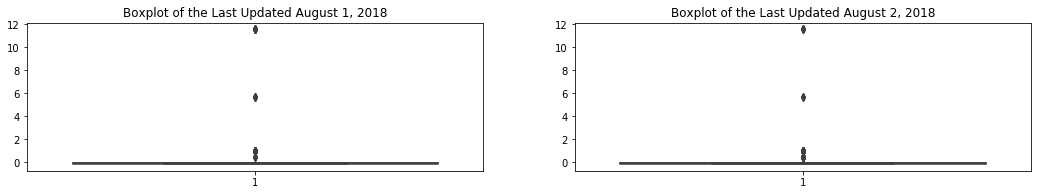

In [144]:
#Realizamos algunos BoxPlots para entender la distribucion de la data.
fig = plt.figure(figsize=(18,6)) # create figure

# create subplots
ax5 = fig.add_subplot(2, 2, 1) 
ax6 = fig.add_subplot(2, 2, 2) 
#ax7 = fig.add_subplot(2, 2, 3)
#ax8 = fig.add_subplot(2, 2, 4)

#Subplot 1
ax5 = sns.boxplot(x=df[df[last_up_signif_corr[1]]==1][last_up_signif_corr[1]].values, y=df[df[last_up_signif_corr[1]]==1]['Installs'].values, ax=ax5)
ax5.set_title('Boxplot of the Last Updated ' + last_up_signif_corr[1])

#Subplot 2
ax6 = sns.boxplot(x=df[df[last_up_signif_corr[2]]==1][last_up_signif_corr[2]].values, y=df[df[last_up_signif_corr[2]]==1]['Installs'].values, ax=ax6)
ax6.set_title('Boxplot of the Last Updated ' + last_up_signif_corr[2])

In [112]:
#Entrenamos al modelo de Ordinary Least Squares con la data de Android Ver para buscar la correlacion con la instalaciones
import statsmodels.api as sm
X=df_test_Andr.iloc[:-1,1:]
X=sm.add_constant(X)
y=df_test_Andr.iloc[:-1,0]

results = sm.OLS(y,X).fit()

In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Installs   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     20.70
Date:                Tue, 11 Feb 2020   Prob (F-statistic):          5.10e-115
Time:                        18:23:36   Log-Likelihood:                -15058.
No. Observations:               10839   AIC:                         3.018e+04
Df Residuals:                   10806   BIC:                         3.042e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0674      0.079     -0.857      0.391      -0.221       0.087
1.0 and up            -0.1142      0.672     -0.170      0.865      -1.431       1.202
1.5 and up            -0.1005      0.225     -0.446      0.655      -0.542       0.341
1.6 and up            -0.1098      0.118     -0.933      0.351      -0.340       0.121
2.0 and up            -0.1015      0.184     -0.551      0.582      -0.463       0.260
2.0.1 and up           0.0553      0.365      0.152      0.880      -0.660       0.771
2.1 and up            -0.0880      0.113     -0.777      0.437      -0.310       0.134
2.2 - 7.1.1           -0.1145      0.946     -0.121      0.904      -1.970       1.741
2.2 and up            -0.1098      0.099     -1.107      0.268      -0.304       0.085
2.3 and up            -0.0659      0.087     -0.758      0.448      -0.236       0.104
2.3.3 and up          -0.0726      0.097     -0.751      0.453      -0.262       0.117
3.0 and up            -0.0860      0.099     -0.866      0.386      -0.281       0.109
3.1 and up            -0.0544      0.308     -0.176      0.860      -0.659       0.550
3.2 and up            -0.1118      0.176     -0.636      0.525      -0.456       0.233
4.0 and up             0.0019      0.083      0.023      0.982      -0.160       0.164
4.0.3 - 7.1.1         -0.0263      0.672     -0.039      0.969      -1.343       1.290
4.0.3 and up          -0.0557      0.082     -0.676      0.499      -0.217       0.106
4.1 - 7.1.1            1.0616      0.946      1.122      0.262      -0.794       2.917
4.1 and up             0.0331      0.081      0.410      0.682      -0.125       0.192
4.2 and up            -0.0555      0.092     -0.604      0.546      -0.236       0.125
4.3 and up            -0.0652      0.099     -0.657      0.511      -0.260       0.129
4.4 and up             0.0287      0.084      0.341      0.733      -0.136       0.194
4.4W and up           -0.1145      0.283     -0.404      0.686      -0.670       0.441
5.0 - 6.0             -0.1144      0.946     -0.121      0.904      -1.970       1.741
5.0 - 7.1.1           -0.1145      0.946     -0.121      0.904      -1.970       1.741
5.0 - 8.0              0.0031      0.672      0.005      0.996      -1.313       1.319
5.0 and up            -0.0703      0.088     -0.803      0.422      -0.242       0.101
5.1 and up            -0.1104      0.208     -0.531      0.596      -0.518       0.297
6.0 and up            -0.1005      0.145     -0.693      0.488      -0.385       0.184
7.0 - 7.1.1           -0.1027      0.946     -0.109      0.914      -1.958       1.752
7.0 and up            -0.0519      0.165     -0.314      0.753      -0.376       0.272
7.1 and up             0.2816      0.550      0.512      0.609      -0.797       1.360
8.0 and up            -0.1115      0.3

Segun los resultados del Sumary en la feature **Android Ver** no hay valor t que sea significativo por lo tanto seguimos con la siguiente  feature.

In [114]:
#Entrenamos al modelo de Ordinary Least Squares con la data de Content Raiting para buscar la correlacion con la instalaciones
import statsmodels.api as sm
X=df_test_Cont.iloc[:-1,1:]
X=sm.add_constant(X)
y=df_test_Cont.iloc[:-1,0]

results = sm.OLS(y,X).fit()

In [115]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Installs   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.73
Date:                Tue, 11 Feb 2020   Prob (F-statistic):           2.62e-10
Time:                        18:25:10   Log-Likelihood:                -15354.
No. Observations:               10839   AIC:                         3.072e+04
Df Residuals:                   10833   BIC:                         3.076e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.843e+11    1.8e+12     -0.103      0.918   -3.71e+12    3.34e+12
Adults only 18+  1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
Everyone         1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
Everyone 10+     1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
Mature 17+       1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
Teen             1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
Unrated          1.843e+11    1.8e+12      0.103      0.918   -3.34e+12    3.71e+12
==============================================================================
Omnibus:                    16241.046   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4641211.714
Skew:                           9.527   Prob(JB):                         0.00
Kurtosis:                     102.567   Cond. No.                     6.50e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.4e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Segun los resultados del Sumary en la feature **Content Raiting** no hay valor t que sea significativo por lo tanto seguimos con la siguiente  feature.

## Conclusion 

Despues de un breve analisis de la data podemos decir que las features con correlacion con la cantidad de instalaciones son:

- **Reviews** muestra una relacion lineal con las Instalaciones con un p-values de 0.6431

Text(0, 0.5, 'Installs')

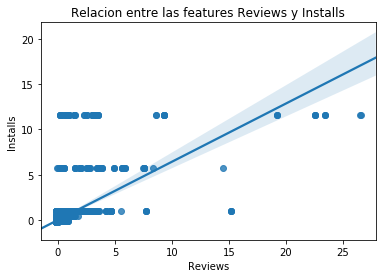

In [132]:
ax4 = sns.regplot(x=df['Reviews'].values, y=df['Installs'].values)
plt.title('Relacion entre las features Reviews y Installs')
plt.xlabel('Reviews')
plt.ylabel('Installs')

- De la feature **Current Ver**, gracias al resultado del t-test podemos decir con un 95% de certeza que en las siguientes versiones no podemos rechazar la hipotesis nula propuesta.

In [151]:
#Por una cuestion de espacio mostrare algunos de los valores que cumplen la condicion mencionada
df_results_cv[df_results_cv['p-values']<=0.05][2:].head()

,t-values,p-values
1.129.0.2,15.835295,1.233998e-55
1.37.2,2.217329,2.662857e-02
1.4.77,11.975160,9.123777e-33
1.49.1,14.662594,4.680634e-48
1.90.0,29.597167,8.628884e-183


- De la feature **Last Updated**, gracias al resultado del t-test podemos decir con un 95% de certeza que en las siguientes versiones no podemos rechazar la hipotesis nula propuesta.

In [153]:
#Por una cuestion de espacio mostrare algunos de los valores que cumplen la condicion mencionada
df_results_lu[df_results_lu['p-values']<=0.05][2:].head()

,t-values,p-values
"August 2, 2018",6.684115,2.454369e-11
"August 3, 2018",11.206908,5.738136e-29
"August 4, 2018",2.794964,5.201001e-03
"August 6, 2018",13.902764,1.630193e-43
"July 11, 2018",2.009639,4.449780e-02
